# Transformer Interpretability Using Layer-wise Relevance Propagation

Authors: Rohan Subramanian, Sahil Rane and Forrest Bicker

In this notebook, we apply interpretability methods such as Layer-wise Relevance Propagation (LRP) to vision transformers.

We used the approach proposed by Hila Chefer et al. 2021 in the paper "Transformer Interpretability Beyond Attention Visualization." We used their code <a href='Transformer Interpretability Beyond Attention Visualization'>available on Github</a> with modifications to work on our specific application to CIFAR-10. They have implemented the vision transformer using custom classes compatible with LRP. We wrote the code below to fine-tune the vision transformer for CIFAR-10 and remain compatible with the LRP computations and apply it to CIFAR-10 classification.

## Load packages

In [1]:
# Check that we are using the environment copy of python
import sys
print(sys.executable)

/mnt/cs/cs152/individual/3b1b/myenv/bin/python


In [2]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.


In [2]:
import os
os.chdir(f'./Transformer-Explainability')
print(os.getcwd())

/mnt/cs/cs152/individual/3b1b/Transformer-Explainability


In [3]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from datasets import load_dataset
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Run this cell to clear GPU cache
import gc
torch.cuda.empty_cache()
gc.collect()

40

# Load data and initialize model

In [5]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()

In [6]:
# Load a subset of CIFAR-10
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])

# Split into training, test and validation
splits = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds = splits['train']
val_ds = splits['test']

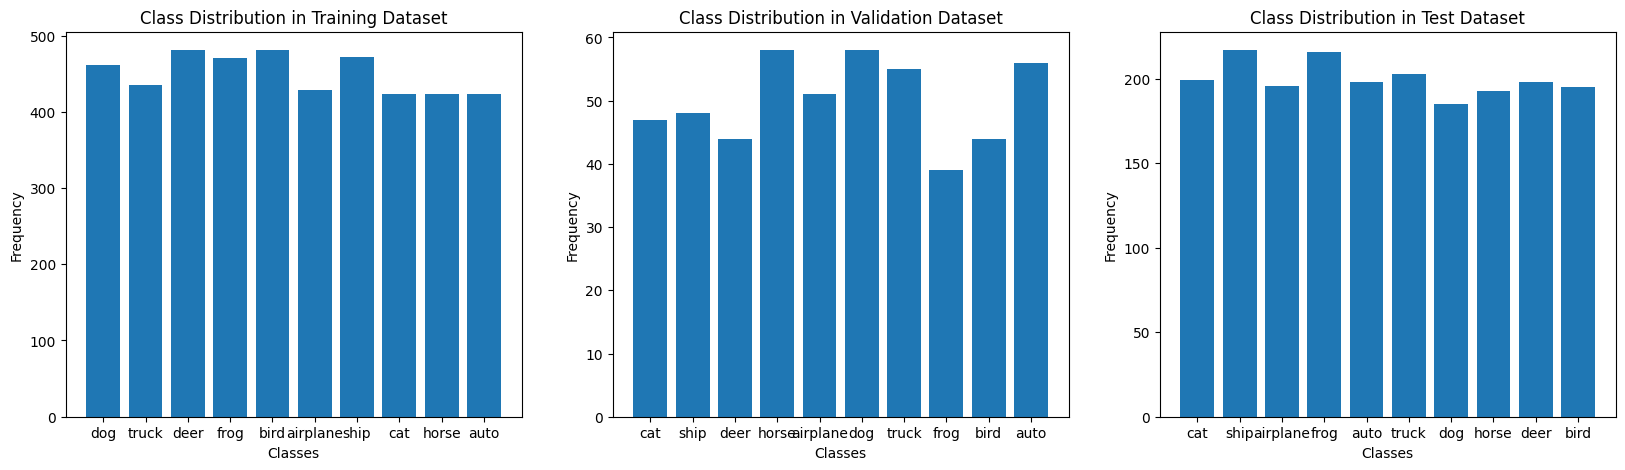

In [55]:
from collections import Counter

namesdict = {0: 'airplane', 1: 'auto', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def get_class_distribution(dataset):
    labels = [namesdict[item['label']] for item in dataset]  # Assuming item[1] is the label
    return Counter(labels)

train_class_dist = get_class_distribution(train_ds)
val_class_dist = get_class_distribution(val_ds)
test_class_dist = get_class_distribution(test_ds)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Function to plot class distribution on a given axis
def plot_class_distribution(ax, class_dist, dataset_name):
    classes = list(class_dist.keys())
    frequencies = list(class_dist.values())

    ax.bar(classes, frequencies)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Class Distribution in {dataset_name} Dataset')

# Plotting class distributions on different axes
plot_class_distribution(axes[0], train_class_dist, 'Training')
plot_class_distribution(axes[1], val_class_dist, 'Validation')
plot_class_distribution(axes[2], test_class_dist, 'Test')

In [60]:
plt.tight_layout()
fig.savefig('../figures/class_distribution.pdf')

<Figure size 640x480 with 0 Axes>

In [8]:
# Iterate over random elements in test_ds and download 25 images to samples folder
for i in range(25):
  img = (test_ds[i]['img'])
  img.save(f'../figures/cifar10_{i}.png')

In [9]:
# Unfortunately, none of these were birds so let's add some birds
bird_inds = [35, 65, 75, 84]
for i in bird_inds:
    img = (test_ds[i]['img'])
    img.save(f'../figures/cifar10_{i}.png')

In [7]:
CLS2IDX = {id:label for id, label in enumerate(train_ds.features['label'].names)}
IDX2CLS = {label:id for id,label in CLS2IDX.items()}
CLS2IDX

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Preprocessing data

In [8]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [9]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [10]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [11]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return [pixel_values, labels]

train_loader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=32)
val_loader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=32)
test_loader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=32)

# Fine-tune the model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a custom head
num_classes = 10
from modules.layers_lrp import Linear
model.head = Linear(model.head.in_features, num_classes)

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Fine-tune the model
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_correct_train = 0
    total_train_samples = 0
    epoch_losses, epoch_accuracies = [], []
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_correct_train += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

        batch_accuracy = (predicted == labels).float().mean().item()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(batch_accuracy)

        # Print every 10 batches
        if (i + 1) % 10 == 0:
            print(f"Batch {i+1} Loss: {loss.item()}, Accuracy: {batch_accuracy}")

    train_losses.append(epoch_losses)
    train_accuracies.append(epoch_accuracies)
    print('Epoch training done')
    
    # Evaluate the model
    model.eval()
    total_correct = 0
    total_samples = 0
    epoch_val_losses, epoch_val_accuracies = [], []
    
    for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            batch_accuracy = (predicted == labels).float().mean().item()
            epoch_val_accuracies.append(batch_accuracy)

    val_losses.append(epoch_val_losses)
    val_accuracies.append(epoch_val_accuracies)

    val_accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy}")



Epoch 1/3
Batch 10 Loss: 2.2417349815368652, Accuracy: 0.1875
Batch 20 Loss: 1.967509150505066, Accuracy: 0.4375
Batch 30 Loss: 1.91316819190979, Accuracy: 0.4375
Batch 40 Loss: 1.8569939136505127, Accuracy: 0.46875
Batch 50 Loss: 1.4429374933242798, Accuracy: 0.71875
Batch 60 Loss: 1.1818294525146484, Accuracy: 0.78125
Batch 70 Loss: 1.2255570888519287, Accuracy: 0.78125
Batch 80 Loss: 0.915151834487915, Accuracy: 0.9375
Batch 90 Loss: 0.7902311086654663, Accuracy: 0.90625
Batch 100 Loss: 0.6295070052146912, Accuracy: 1.0
Batch 110 Loss: 0.6064029335975647, Accuracy: 0.9375
Batch 120 Loss: 0.6669278740882874, Accuracy: 0.84375
Batch 130 Loss: 0.48383206129074097, Accuracy: 1.0
Batch 140 Loss: 0.37959757447242737, Accuracy: 0.96875
Epoch training done
Epoch 1/3, Validation Accuracy: 0.952
Epoch 2/3
Batch 10 Loss: 0.38632628321647644, Accuracy: 0.96875
Batch 20 Loss: 0.3755742013454437, Accuracy: 0.9375
Batch 30 Loss: 0.4072219729423523, Accuracy: 0.9375
Batch 40 Loss: 0.387006789445877

In [28]:
# Save model
torch.save(model.state_dict(), '../models/vit_cifar10_lrp.pth')

In [15]:
# Reload model from saved state
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from modules.layers_lrp import Linear
model = vit_LRP(pretrained=True)
model.head = Linear(model.head.in_features, 10)
model.load_state_dict(torch.load('../models/vit_cifar10_lrp.pth'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (matmul1): einsum()
        (matmul2): einsum()
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (add1): Add()
      (add2): Add()
      (clone1): Clone()
      (clone2): Cl

# Model evaluation

In [16]:
# Compute overall accuracy
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        if isinstance(logits, torch.distributed.rpc.api.RRef):
            logits = logits.local_value()
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    
test_acc = compute_accuracy(model, test_loader, DEVICE)
float(test_acc)

97.70000457763672

In [17]:
# Compute overall ROC-AUC score

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def compute_roc_auc(model, data_loader, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    prediction_scores = []

    for features, targets in data_loader:
        features = features.to(device)

        outputs = model(features)

        with torch.no_grad():  # No need to track gradients for validation
            probabilities = torch.softmax(outputs, dim=1)  # Use softmax for multi-class classification

            true_labels.extend(targets.cpu().numpy())  # Move to CPU and convert to numpy
            prediction_scores.extend(probabilities.cpu().numpy())

    true_labels = label_binarize(true_labels, classes=range(num_classes))
    roc_auc = roc_auc_score(true_labels, prediction_scores, multi_class='ovr')
    return roc_auc

compute_roc_auc(model, test_loader, DEVICE, num_classes=10)

0.9996418104136463

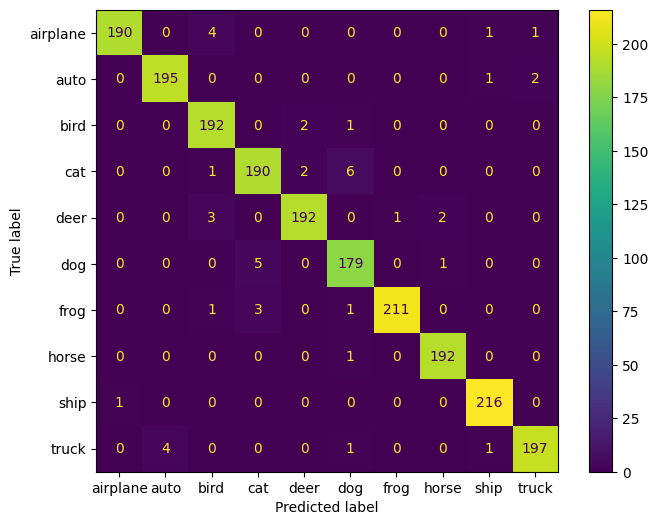

In [104]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_confusion_matrix(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []

    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)

        outputs = model(features)

        with torch.no_grad():  # No need to track gradients for validation
            _, predicted_labels = torch.max(outputs, 1)  # Get the index of the max log-probability

            all_predictions.extend(predicted_labels.cpu().numpy())  # Move to CPU and convert to numpy
            all_targets.extend(targets.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    return cm

cf_matrix = compute_confusion_matrix(model, test_loader, DEVICE)
labels = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
display.plot(ax=ax)
plt.savefig("../figures/vit-cfmat.pdf", format="pdf", bbox_inches="tight")

In [59]:
# Find incorrect predictions
def find_incorrect_predictions(model, data_loader, device):
    model.eval()
    incorrect_indices = []

    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)

        # Find the indices of incorrect predictions
        mask_incorrect = predicted_labels != targets
        incorrect_batch_indices = mask_incorrect.nonzero(as_tuple=False).view(-1).tolist()
        
        # Adjust these indices based on the current batch size
        batch_offset = i * data_loader.batch_size
        incorrect_indices.extend([idx + batch_offset for idx in incorrect_batch_indices])

    return incorrect_indices

incorrect_indices = find_incorrect_predictions(model, test_loader, DEVICE)
len(incorrect_indices)

46

In [109]:
import torch

def compute_class_accuracy(model, data_loader, device):
    model.eval()
    class_correct = dict()
    class_totals = dict()

    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        if isinstance(logits, torch.distributed.rpc.api.RRef):
            logits = logits.local_value()
        _, predicted_labels = torch.max(logits, 1)

        for target, prediction in zip(targets, predicted_labels):
            if target.item() not in class_correct:
                class_correct[target.item()] = 0
                class_totals[target.item()] = 0
            if prediction == target:
                class_correct[target.item()] += 1
            class_totals[target.item()] += 1

    class_accuracies = {cls: (class_correct[cls] / class_totals[cls]) * 100 
                        for cls in class_correct}

    return class_accuracies

# Example usage:
class_accuracies = compute_class_accuracy(model, test_loader, DEVICE)
for class_id, acc in class_accuracies.items():
    print(f"Accuracy for class {CLS2IDX[class_id]}: {acc:.2f}%")

Accuracy for class cat: 95.48%
Accuracy for class ship: 99.54%
Accuracy for class airplane: 96.94%
Accuracy for class frog: 97.69%
Accuracy for class automobile: 98.48%
Accuracy for class truck: 97.04%
Accuracy for class dog: 96.76%
Accuracy for class horse: 99.48%
Accuracy for class deer: 96.97%
Accuracy for class bird: 98.46%


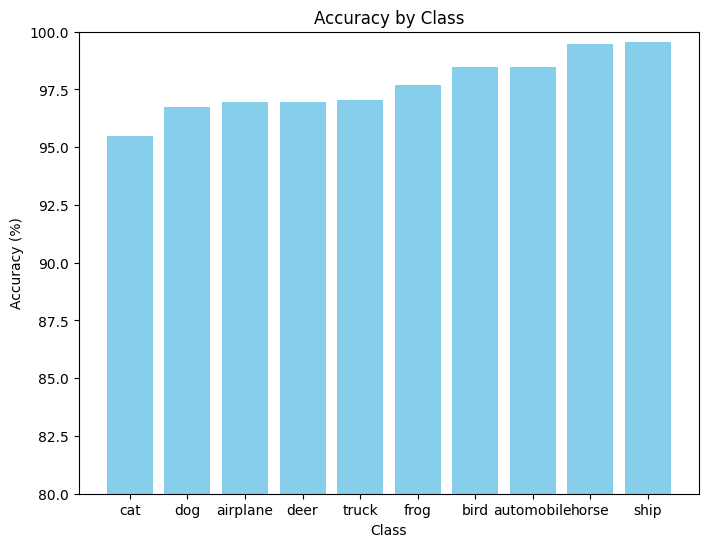

In [119]:
# Sorting the dictionary by its values and then unpacking into separate lists
sorted_classes, sorted_accuracies = zip(*sorted(class_accuracies.items(), key=lambda x: x[1]))
sorted_classes = [CLS2IDX[i] for i in sorted_classes]

# Creating the bar chart with sorted data
plt.figure(figsize=(8, 6))

plt.bar(sorted_classes, sorted_accuracies, color='skyblue')

# Adding labels and title
plt.ylim(80,100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Class')
plt.xticks(sorted_classes)  # Set x-ticks to sorted class labels
plt.savefig("../figures/vit-classacc.pdf")
plt.show()

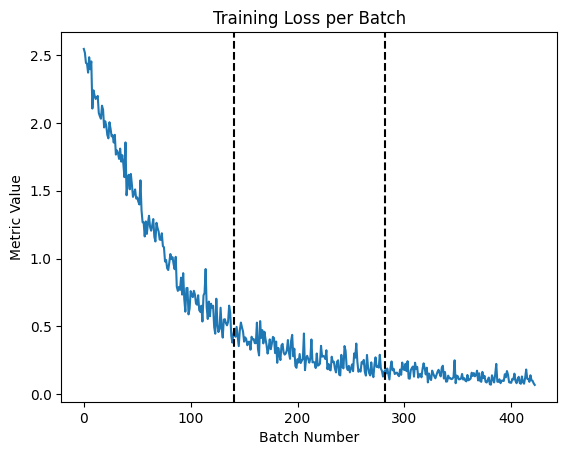

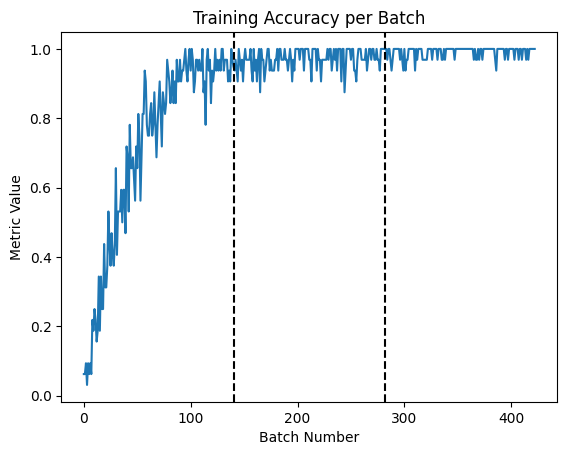

In [107]:
# Plot training loss and accuracy per batch
def flatten_metrics(metrics):
    # Flatten the list of lists
    flattened = [item for sublist in metrics for item in sublist]
    return flattened

# Calculate the positions for the vertical lines (end of each epoch)
def calculate_epoch_end_positions(metrics):
    positions = []
    counter = 0
    for epoch_metrics in metrics:
        counter += len(epoch_metrics)
        positions.append(counter)
    return positions[:-1]  # Exclude the last position

# Flatten the metrics
flat_train_losses = flatten_metrics(train_losses)
flat_train_accuracies = flatten_metrics(train_accuracies)

# Calculate epoch end positions
epoch_end_positions = calculate_epoch_end_positions(train_losses)  # Assuming train and val have the same number of batches per epoch

def plot_metrics_with_epochs(metrics, epoch_positions, title, filename):
    plt.figure()
    plt.plot(metrics)

    # Add vertical lines for epoch demarcation
    for pos in epoch_positions:
        plt.axvline(x=pos, color='black', linestyle='--')

    plt.title(title)
    plt.xlabel('Batch Number')
    plt.ylabel('Metric Value')
    plt.savefig(f"../figures/{filename}.pdf", format='pdf')
    plt.show()

# Plotting
plot_metrics_with_epochs(flat_train_losses, epoch_end_positions, 'Training Loss per Batch', "vit-batchloss")
plot_metrics_with_epochs(flat_train_accuracies, epoch_end_positions, 'Training Accuracy per Batch', "vit-batchacc")


# Explainability Using LRP

In [16]:
from baselines.ViT.ViT_explanation_generator import LRP

model.eval()
attribution_generator = LRP(model)

def show_cam_on_image(img, mask):
    # create heatmap from mask on image
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    # Compute LRP values and overlay on the original image 
    
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions

    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

    # make a bar plot
    prob_np = prob.cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.bar(class_names, prob_np[0, class_indices])
    plt.title('Top-5 classes')
    plt.xlabel('Class')
    plt.ylabel('Probability')

def print_top_classes(predictions):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    
    class_names = [CLS2IDX[cls_idx] for cls_idx in class_indices]

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += '\t\tvalue = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

    # Prepare data for bar plot
    prob_np = prob.cpu().numpy()
    return class_names, prob_np[0, class_indices]    

Let's visualize LRP for a correctly predicted example for each of the 10 classes.

Top 5 classes:
	3 : cat		value = 4.671	 prob = 94.7%
	2 : bird		value = 0.022	 prob = 0.9%
	4 : deer		value = -0.011	 prob = 0.9%
	5 : dog		value = -0.230	 prob = 0.7%
	8 : ship		value = -0.343	 prob = 0.6%


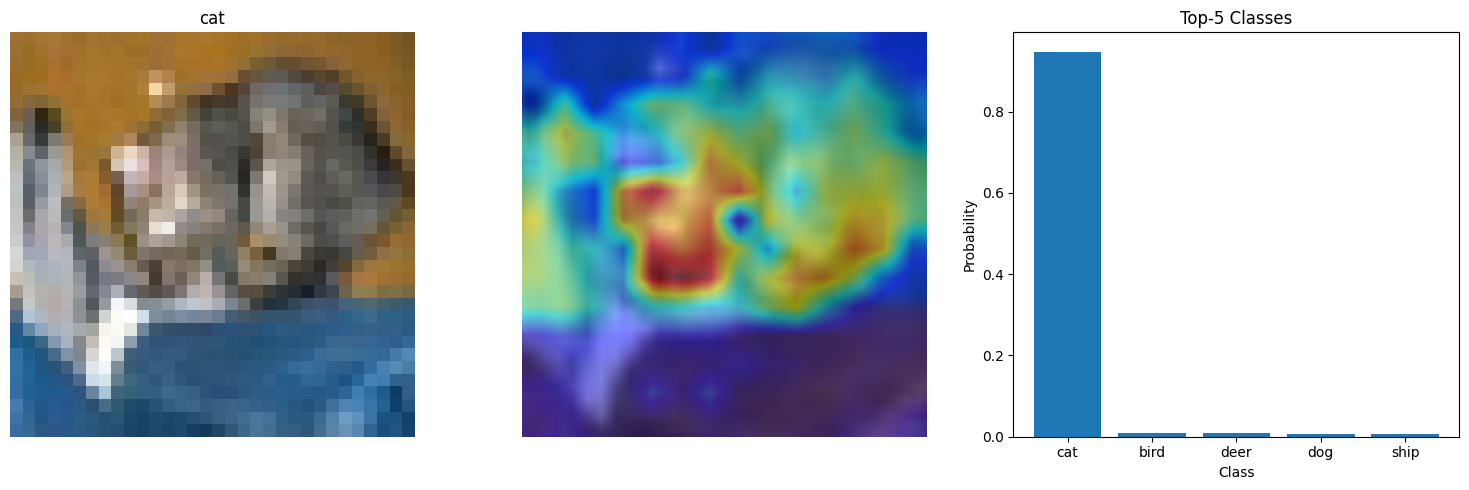

Top 5 classes:
	8 : ship		value = 4.034	 prob = 87.5%
	0 : airplane		value = 1.162	 prob = 5.0%
	1 : automobile		value = 0.613	 prob = 2.9%
	2 : bird		value = -0.223	 prob = 1.2%
	9 : truck		value = -0.356	 prob = 1.1%


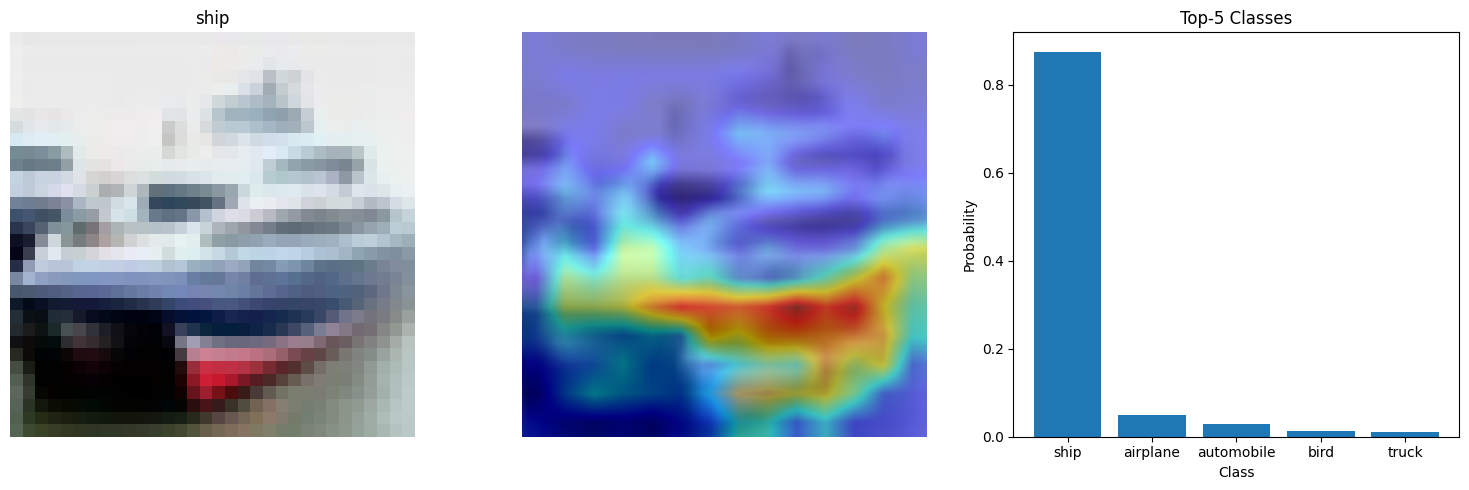

Top 5 classes:
	0 : airplane		value = 4.678	 prob = 94.4%
	6 : frog		value = 0.132	 prob = 1.0%
	2 : bird		value = 0.106	 prob = 1.0%
	9 : truck		value = -0.024	 prob = 0.9%
	8 : ship		value = -0.293	 prob = 0.7%


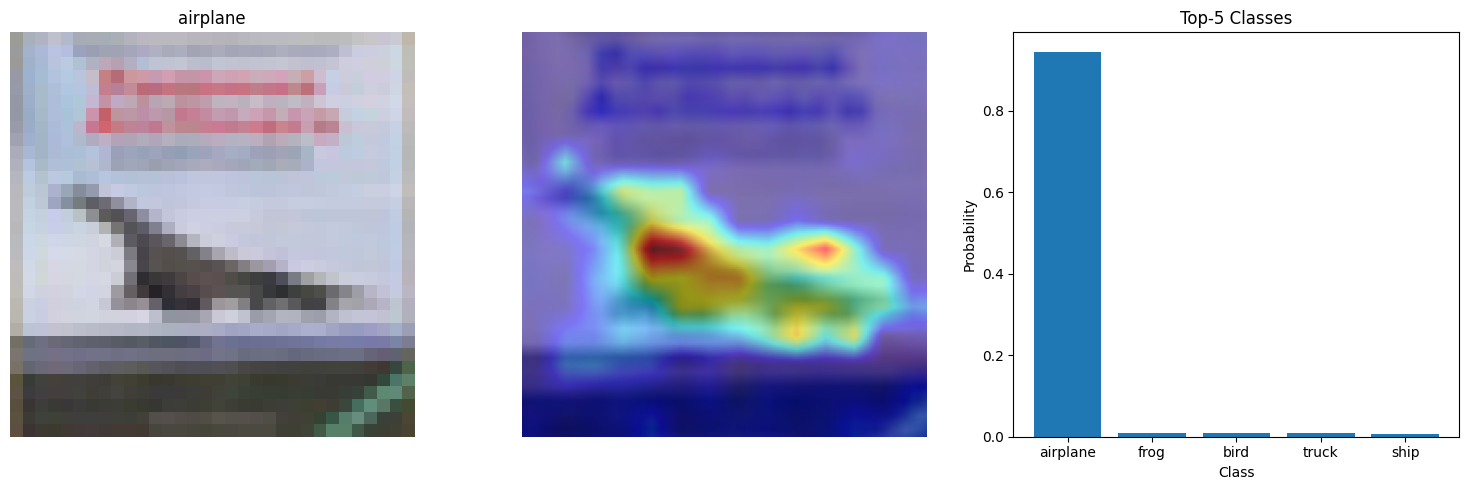

Top 5 classes:
	6 : frog		value = 5.398	 prob = 96.8%
	4 : deer		value = 0.159	 prob = 0.5%
	1 : automobile		value = 0.072	 prob = 0.5%
	0 : airplane		value = -0.002	 prob = 0.4%
	2 : bird		value = -0.154	 prob = 0.4%


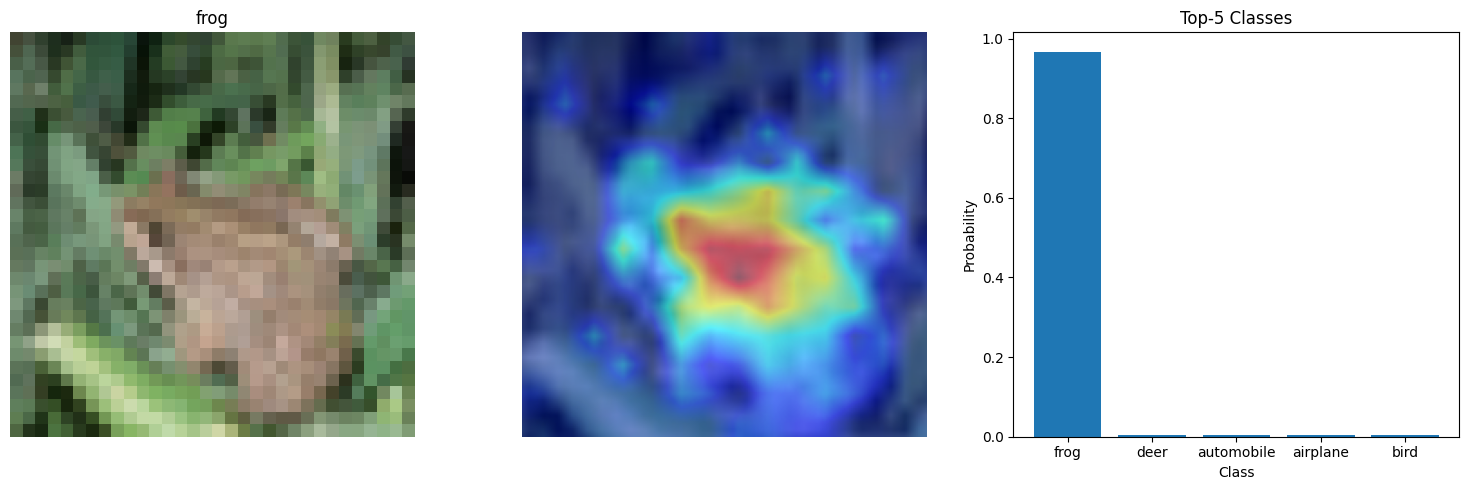

Top 5 classes:
	9 : truck		value = 2.711	 prob = 51.0%
	1 : automobile		value = 2.270	 prob = 32.8%
	5 : dog		value = 0.215	 prob = 4.2%
	8 : ship		value = -0.017	 prob = 3.3%
	7 : horse		value = -0.536	 prob = 2.0%


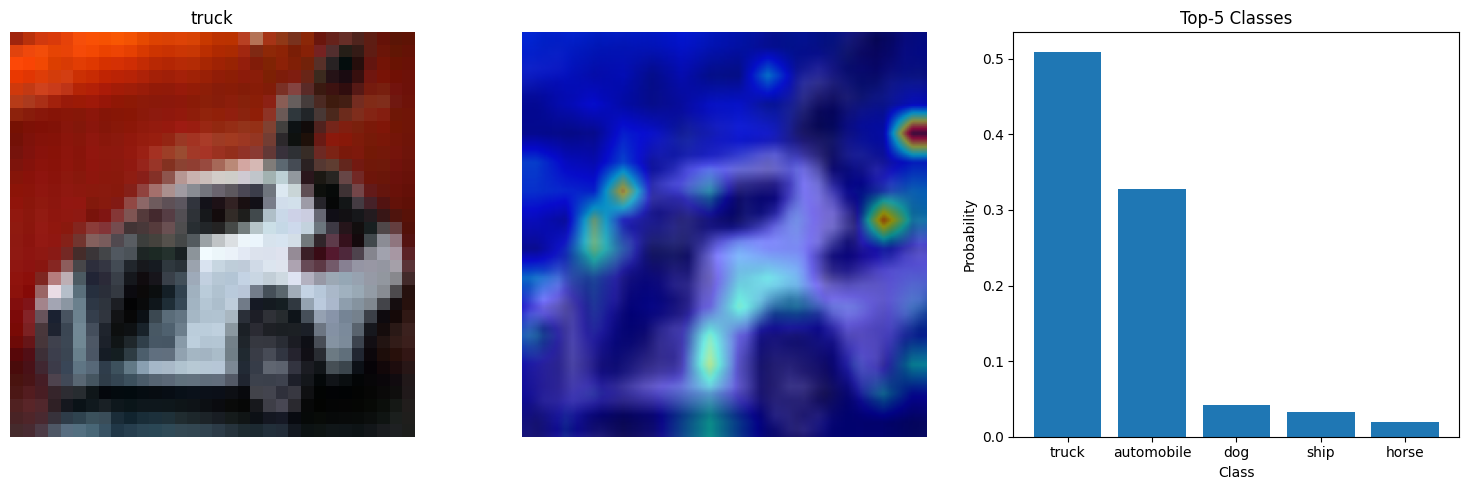

Top 5 classes:
	9 : truck		value = 4.891	 prob = 95.8%
	1 : automobile		value = 0.445	 prob = 1.1%
	4 : deer		value = -0.093	 prob = 0.7%
	5 : dog		value = -0.236	 prob = 0.6%
	7 : horse		value = -0.483	 prob = 0.4%


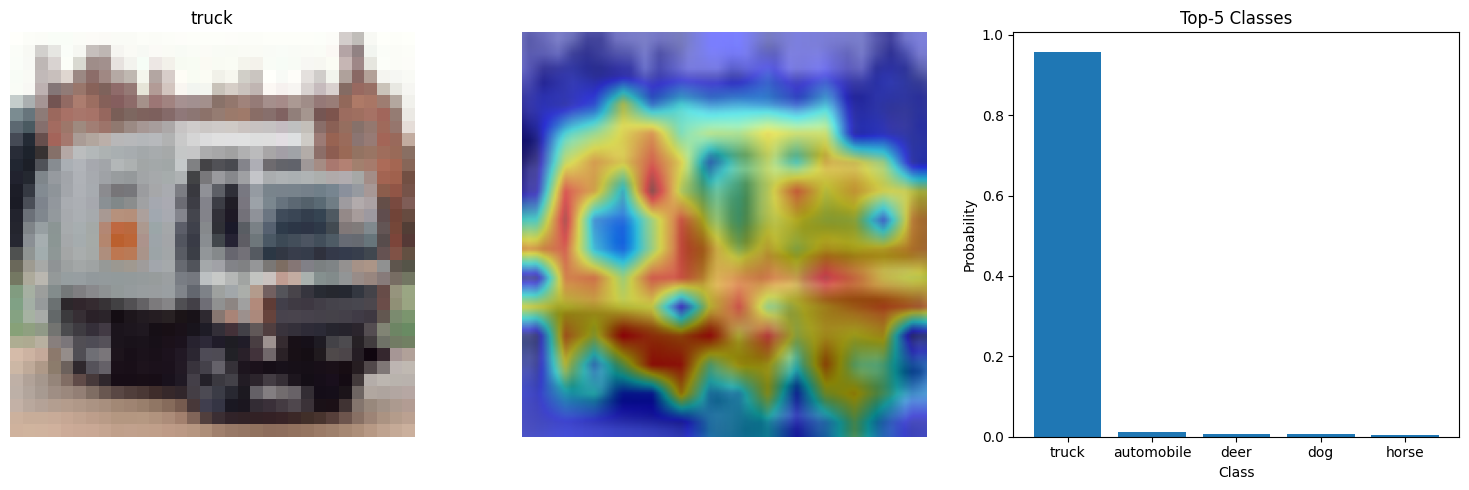

Top 5 classes:
	6 : frog		value = 4.590	 prob = 93.6%
	2 : bird		value = 0.184	 prob = 1.1%
	5 : dog		value = 0.086	 prob = 1.0%
	7 : horse		value = -0.041	 prob = 0.9%
	3 : cat		value = -0.077	 prob = 0.9%


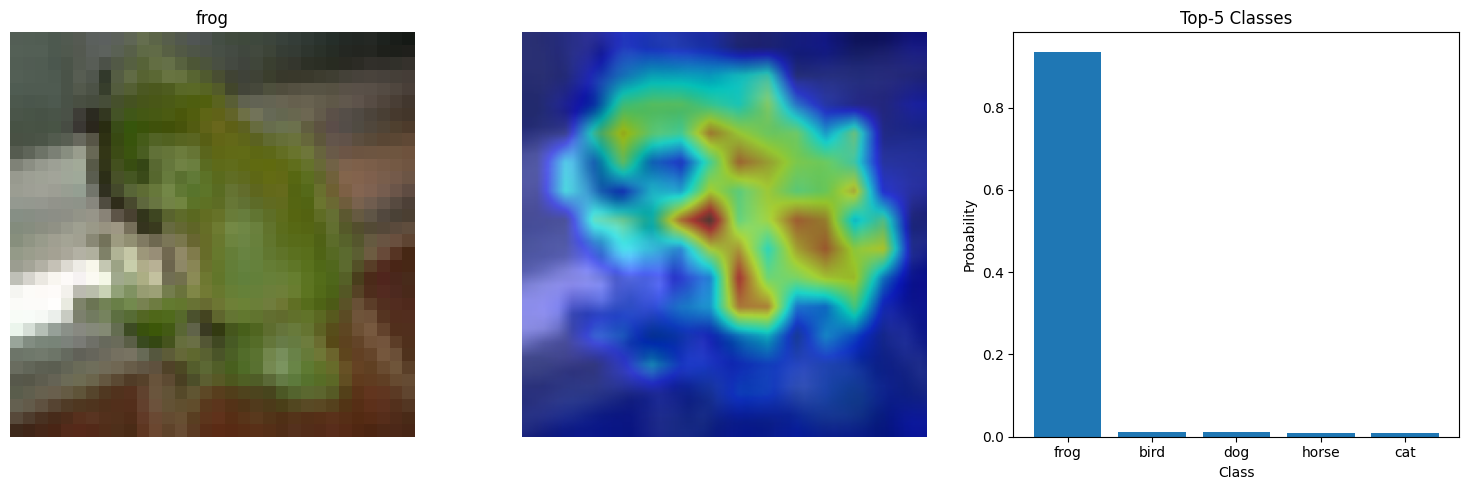

Top 5 classes:
	7 : horse		value = 4.801	 prob = 95.3%
	5 : dog		value = 0.600	 prob = 1.4%
	4 : deer		value = 0.137	 prob = 0.9%
	2 : bird		value = -0.213	 prob = 0.6%
	9 : truck		value = -0.520	 prob = 0.5%


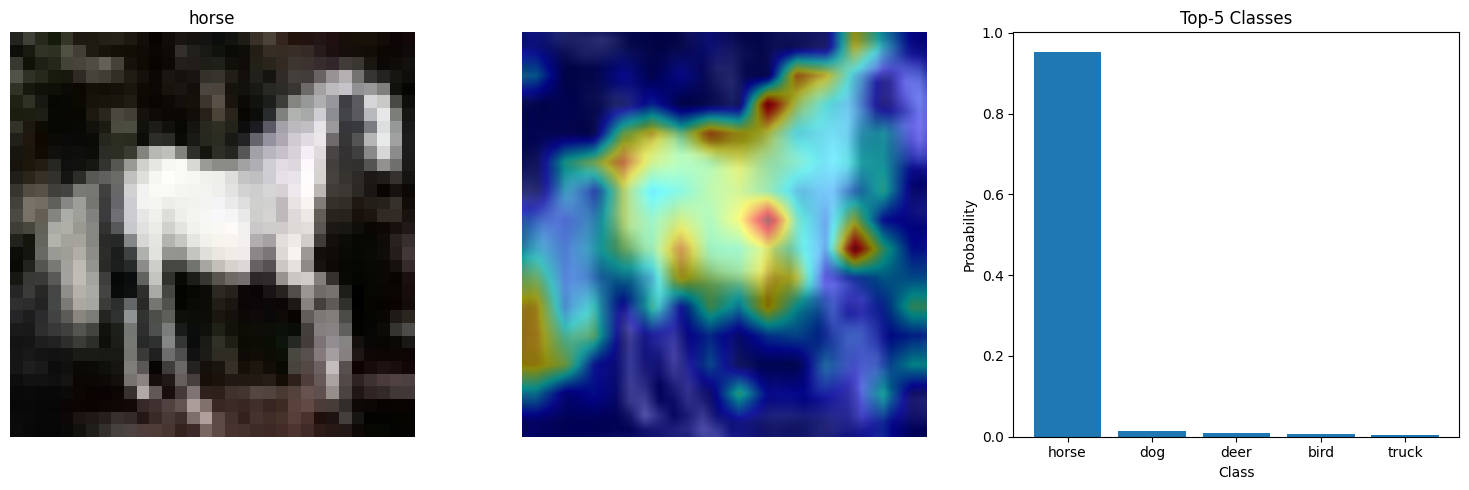

Top 5 classes:
	4 : deer		value = 4.470	 prob = 93.5%
	0 : airplane		value = 0.214	 prob = 1.3%
	2 : bird		value = 0.165	 prob = 1.3%
	7 : horse		value = -0.124	 prob = 0.9%
	3 : cat		value = -0.487	 prob = 0.7%


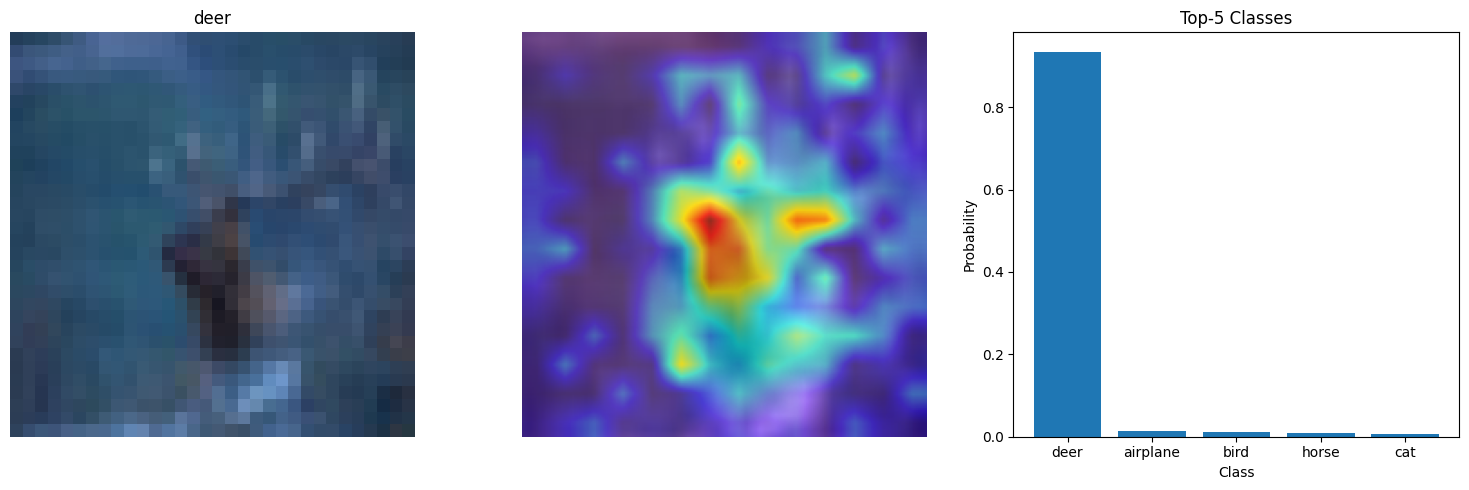

Top 5 classes:
	5 : dog		value = 3.745	 prob = 83.0%
	2 : bird		value = 0.840	 prob = 4.5%
	7 : horse		value = 0.751	 prob = 4.2%
	3 : cat		value = 0.462	 prob = 3.1%
	4 : deer		value = -0.273	 prob = 1.5%


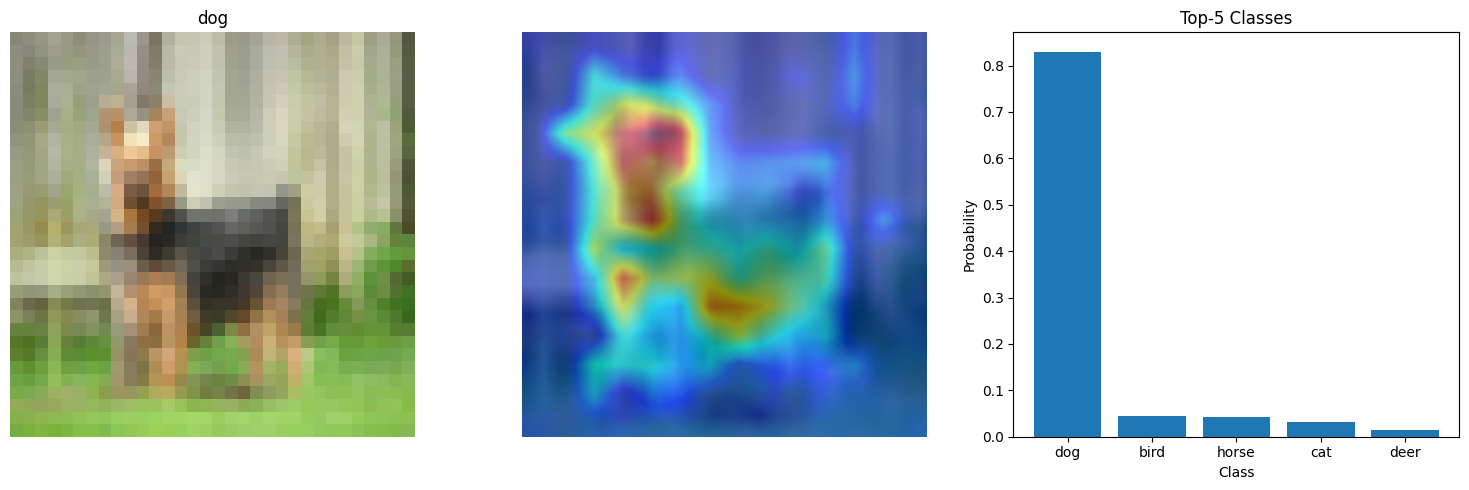

Top 5 classes:
	2 : bird		value = 3.785	 prob = 86.9%
	4 : deer		value = 0.265	 prob = 2.6%
	9 : truck		value = -0.204	 prob = 1.6%
	8 : ship		value = -0.211	 prob = 1.6%
	6 : frog		value = -0.241	 prob = 1.6%


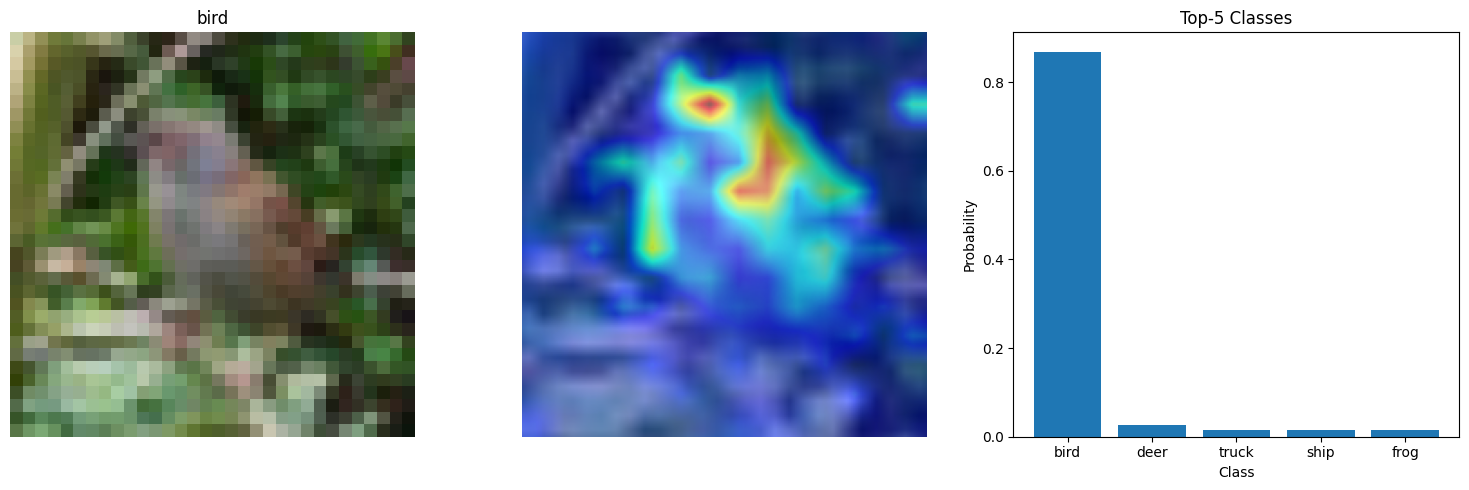

In [20]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

inds = [0, 1, 3, 4, 6, 11, 7, 13, 22, 24, 65]

for i in inds:
    image = Image.open(f'../figures/cifar10_{i}.png')

    transformed_image = transform(image)

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    
    axs[0].imshow(image)
    axs[0].axis('off')

    # Visualize the propagated relevance the predicted class
    cat = generate_visualization(transformed_image)

    axs[1].imshow(cat)
    axs[1].axis('off')

    # Generate predictions and get data for bar plot
    output = model(transformed_image.unsqueeze(0).cuda())
    with torch.no_grad():
        class_names, class_probs = print_top_classes(output)

    # Plot the bar chart in the third subplot
    axs[2].bar(class_names, class_probs)
    axs[2].set_title('Top-5 Classes')
    axs[2].set_xlabel('Class')
    axs[2].set_ylabel('Probability')

    axs[0].set_title(class_names[0])
    
    # Save the plots
    plt.tight_layout()
    plt.savefig(f'../figures/vit_lrp_{class_names[0]}.pdf', bbox_inches='tight')
    plt.show()


Let's now focus on incorrectly classified examples:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


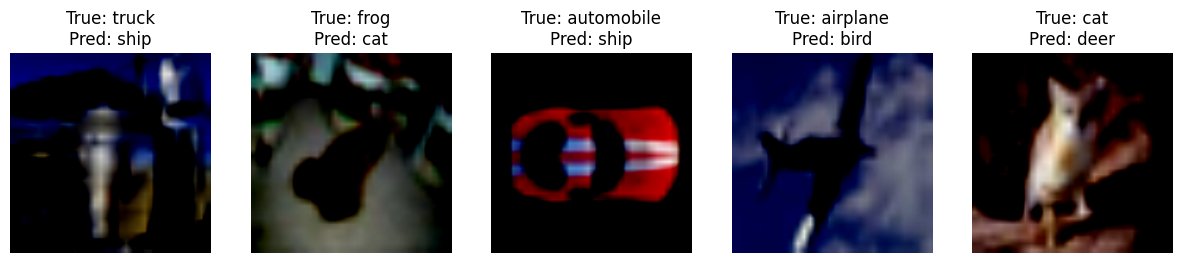

In [129]:
def show_incorrect_classifications(model, data_loader, device, incorrect_indices, num_images=5):
    model.eval()
    # Only display a certain number of images (default is 5)
    to_display = incorrect_indices[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(to_display):
        # Access the image and true label
        image = data_loader.dataset[idx]['pixel_values']
        true_label = data_loader.dataset[idx]['label']
        image = image.to(device).unsqueeze(0)

        # Predict
        logits = model(image)
        _, predicted_label = torch.max(logits, 1)
        
        with torch.no_grad():
            # Convert image tensor to numpy array and display
            image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            axes[i].imshow(image_np)
            axes[i].axis('off')
            axes[i].set_title(f"True: {CLS2IDX[true_label]}\nPred: {CLS2IDX[predicted_label.item()]}")
    plt.savefig("../figures/vit-incorrect-examples.pdf", bbox_inches="tight")
    plt.show()

# Usage
show_incorrect_classifications(model, test_loader, DEVICE, incorrect_indices)

In [143]:
# Save incorrect images for future use
for i, ind in enumerate(incorrect_indices):
  img = (test_ds[ind]['img'])
  img.save(f'../figures/cifar10_incorrect_{ind}.png')

0
Top 5 classes:
	5 : dog		value = 2.818	 prob = 49.1%
	3 : cat		value = 2.449	 prob = 34.0%
	2 : bird		value = 0.821	 prob = 6.7%
	8 : ship		value = -0.365	 prob = 2.0%
	7 : horse		value = -0.448	 prob = 1.9%


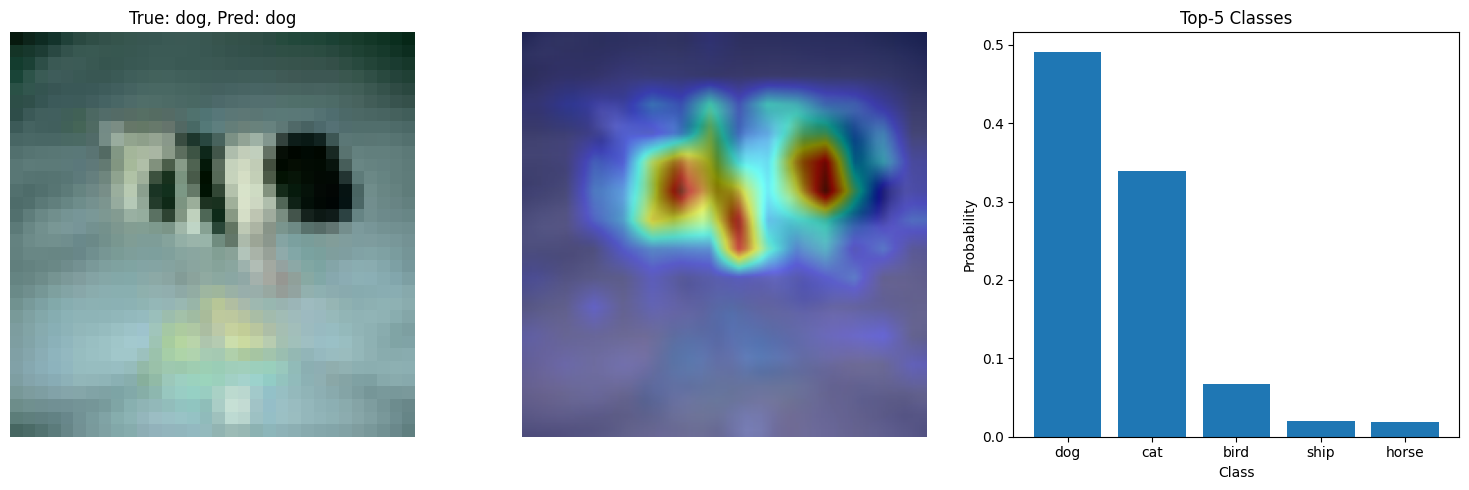

1
Top 5 classes:
	3 : cat		value = 2.281	 prob = 49.3%
	5 : dog		value = 1.073	 prob = 14.7%
	6 : frog		value = 0.599	 prob = 9.2%
	4 : deer		value = 0.357	 prob = 7.2%
	0 : airplane		value = 0.173	 prob = 6.0%


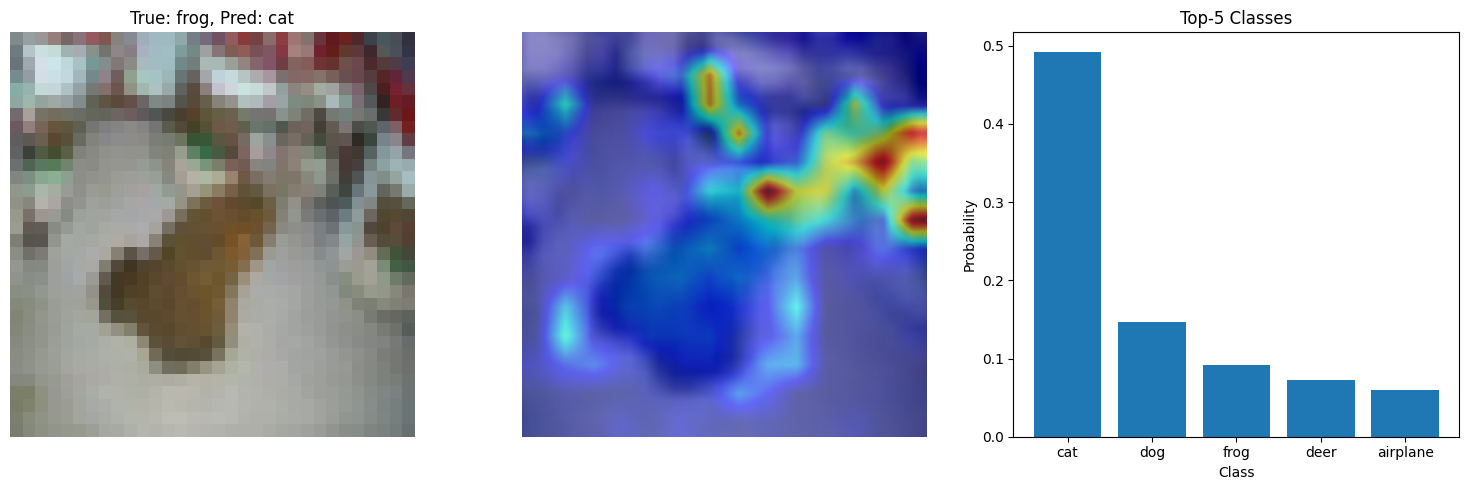

2
Top 5 classes:
	8 : ship		value = 0.846	 prob = 22.1%
	0 : airplane		value = 0.455	 prob = 15.0%
	5 : dog		value = 0.196	 prob = 11.5%
	7 : horse		value = 0.055	 prob = 10.0%
	3 : cat		value = -0.062	 prob = 8.9%


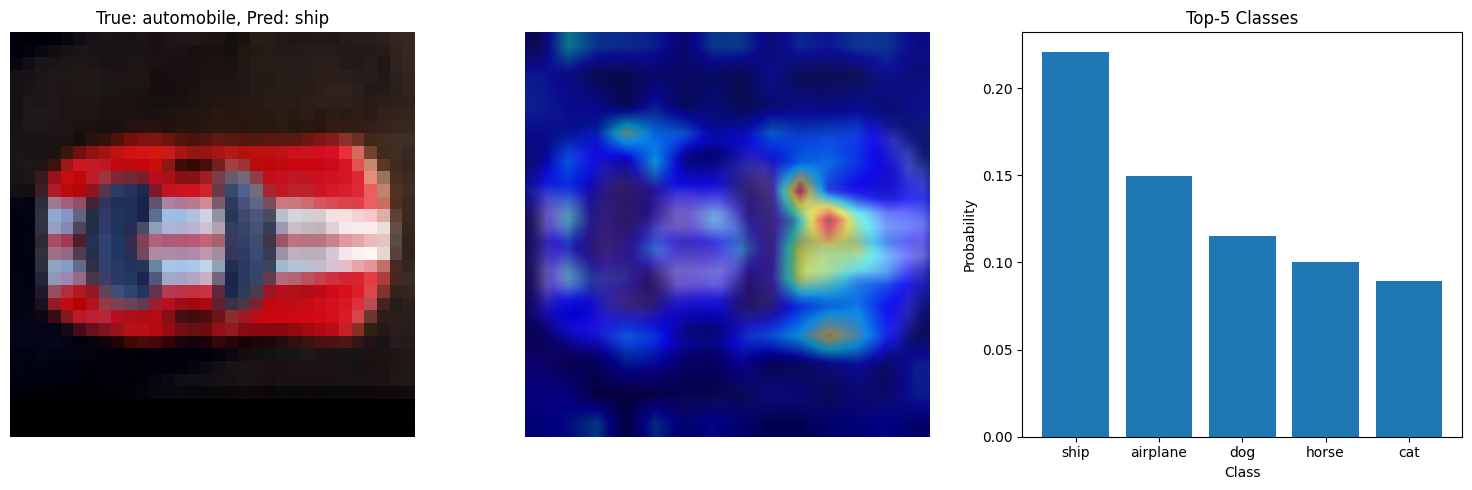

3
Top 5 classes:
	4 : deer		value = 1.965	 prob = 45.2%
	3 : cat		value = 1.129	 prob = 19.6%
	5 : dog		value = 0.491	 prob = 10.4%
	2 : bird		value = 0.032	 prob = 6.5%
	7 : horse		value = -0.039	 prob = 6.1%


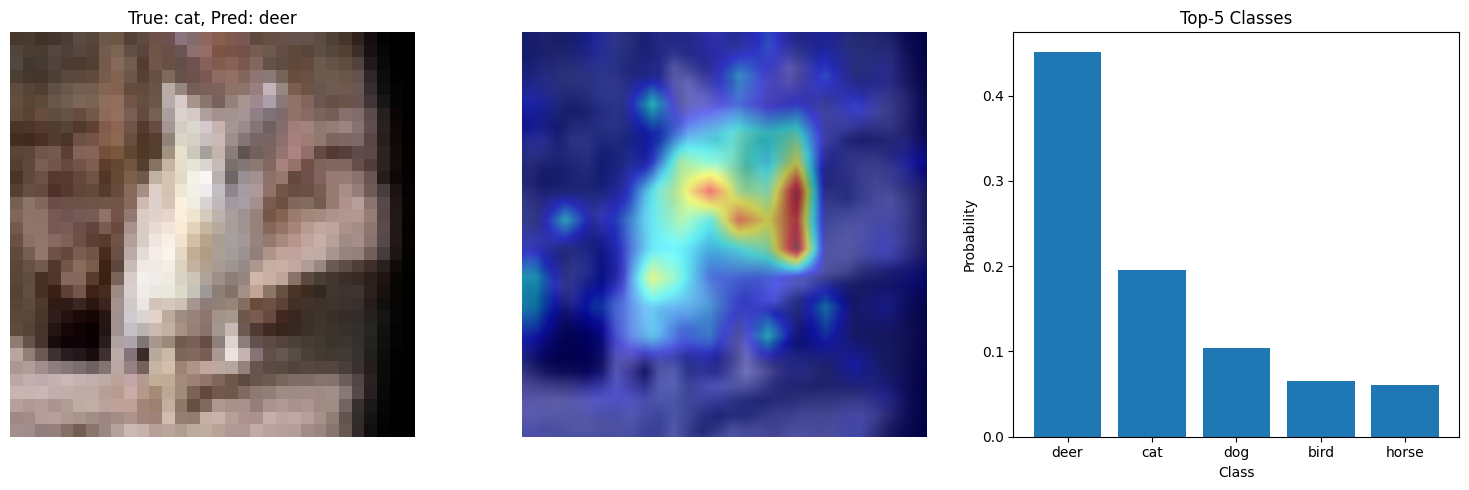

In [27]:
select_incorrect_inds = [42, 59, 81, 127]

for i, ind in enumerate(select_incorrect_inds):
    print(i)
    image = Image.open(f'../figures/cifar10_incorrect_{ind}.png')

    transformed_image = transform(image)

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    
    axs[0].imshow(image)
    axs[0].axis('off')


    # Visualize the propagated relevance the predicted class
    cat = generate_visualization(transformed_image)

    axs[1].imshow(cat)
    axs[1].axis('off')

    # Generate predictions and get data for bar plot
    output = model(transformed_image.unsqueeze(0).cuda())
    with torch.no_grad():
        class_names, class_probs = print_top_classes(output)

    # Plot the bar chart in the third subplot
    axs[2].bar(class_names, class_probs)
    axs[2].set_title('Top-5 Classes')
    axs[2].set_xlabel('Class')
    axs[2].set_ylabel('Probability')

    true_label = CLS2IDX[test_ds[ind]['label']]
    pred_label = class_names[0]
    axs[0].set_title(f"True: {true_label}, Pred: {pred_label}")
    
    # Save the plots
    plt.tight_layout()
    plt.savefig(f'../figures/vit_incorrect_{i}.pdf', bbox_inches='tight')
    plt.show()
